## Load the data:

In [1]:
import warnings
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Suppress specific UserWarnings from openpyxl
warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')

# Define the directory where your files are located
# data_dir = '.'  
data_dir = os.path.join(os.path.pardir) 

# List to hold the dataframes
dataframes = []

# Loop through the years and load the files
for year in range(2005, 2020):
    if year <= 2012:
        file_path = os.path.join(data_dir, f'{year}.xls')
    else:
        file_path = os.path.join(data_dir, f'{year}.xlsx')
    
    # Load the file into a dataframe
    df = pd.read_excel(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes into one
betting_data = pd.concat(dataframes, ignore_index=True)

# Ensure all columns are displayed
pd.set_option('display.max_columns', None)
# Ensure all columns are displayed
pd.set_option('display.max_columns', None)


## Fixing Anomalies

In [2]:
def is_column_numeric(df, column_name):
    # Check if the column contains only numeric values
    return df[column_name].apply(lambda x: str(x).isnumeric()).all()

# Check if columns are numeric before converting
anomaly_column = ['WRank', 'LRank', 'EXW']
for column in anomaly_column:
    if is_column_numeric(betting_data, column):
        print(f"Column '{column}' is numeric.\n")
    else:
        print(f"Column '{column}' is not numeric.\n")

def find_non_numeric_values(df, column_name):
    # Function to check if a value is numeric
    def is_numeric(value):
        try:
            float(value)
            return True
        except ValueError:
            return False

    # Apply the function to the column and filter non-numeric values
    non_numeric_values = df[~df[column_name].apply(is_numeric)]

    # Display the non-numeric values
    print(f"Non-numeric values in {column_name}:")
    print(non_numeric_values[[column_name]])

# WRank column
find_non_numeric_values(betting_data, 'WRank')

# LRank column
find_non_numeric_values(betting_data, 'LRank')

# EXW column
find_non_numeric_values(betting_data, 'EXW')

Column 'WRank' is not numeric.

Column 'LRank' is not numeric.

Column 'EXW' is not numeric.

Non-numeric values in WRank:
Empty DataFrame
Columns: [WRank]
Index: []
Non-numeric values in LRank:
Empty DataFrame
Columns: [LRank]
Index: []
Non-numeric values in EXW:
        EXW
23776  2.,3


In [3]:
# Convert WRank and LRank to numeric, coercing errors
betting_data['WRank'] = pd.to_numeric(betting_data['WRank'], errors='coerce')
betting_data['LRank'] = pd.to_numeric(betting_data['LRank'], errors='coerce')

# Fill NaN values with a high number
betting_data['WRank'].fillna(100000, inplace=True)
betting_data['LRank'].fillna(100000, inplace=True)


# Correct the typo in row 38294, column 'EXW'
if betting_data.at[38294, 'EXW'] == '2.,3':
    betting_data.at[38294, 'EXW'] = '2.3'


## Feature Engineering:

In [4]:
# Now perform the calculations
betting_data['higher_rank_won'] = (betting_data['WRank'] < betting_data['LRank']).astype(int)
betting_data['higher_rank_points'] = betting_data['higher_rank_won'] * betting_data['WPts'] + betting_data['LPts'] * (1 - betting_data['higher_rank_won'])
betting_data['lower_rank_points'] = (1 - betting_data['higher_rank_won']) * betting_data['WPts'] + betting_data['LPts'] * betting_data['higher_rank_won']
betting_data['higher_rank_points'].fillna(0, inplace=True)
betting_data['lower_rank_points'].fillna(0, inplace=True)

all_matches_k = betting_data.copy()

# Columns to drop
# columns_to_drop = [
#     'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment',
#     'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL', 'SBW', 'SBL', 'B365W', 'B365L', 'B&WW', 'B&WL',
#     'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL',
#     'MaxW', 'MaxL', 'AvgW', 'AvgL'
# ]

columns_to_drop = [
    'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment',
    'CBW', 'CBL', 'IWW', 'IWL', 'B365W', 'B365L', 
    'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL',
    'MaxW', 'MaxL', 'AvgW', 'AvgL'
]

# Drop the columns
all_matches_k = all_matches_k.drop(columns=columns_to_drop)

### K-factor model

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss

# Initialize Elo ratings
initial_elo = 1500
players_elo = {}

def win_probability(E_i, E_j):
    return 1 / (1 + 10 ** ((E_j - E_i) / 400))

def get_player_elo(player_name):
    if player_name not in players_elo:
        players_elo[player_name] = initial_elo
    return players_elo[player_name]

def set_player_elo(player_name, elo):
    players_elo[player_name] = elo

def update_elo_k(E_i, E_j, K, outcome):
    pi_j = win_probability(E_i, E_j)  # Calculate win probability for player i against player j
    if outcome == 'win':
        delta_E_i = K * (1 - pi_j)  # Elo rating change for a win
        new_E_i = E_i + delta_E_i
    elif outcome == 'loss':
        delta_E_i = K * (pi_j - 1)  # Elo rating change for a loss
        new_E_i = E_j + delta_E_i
    else:
        raise ValueError("Outcome must be 'win' or 'loss'")
    return new_E_i

def evaluate_model(df):
    logloss_value = log_loss(df.higher_rank_won, df.prob_high_ranked)
    accuracy_value = np.mean(df.match_outcome == df.higher_rank_won)
    calibration_value = np.sum(df.prob_high_ranked) / np.sum(df.higher_rank_won)
    return logloss_value, accuracy_value, calibration_value

def update_elo_and_probabilities_k(df, K):
    for index, match in df.iterrows():
        winner_name, loser_name = match['Winner'], match['Loser']

        # Retrieve current Elo ratings
        winner_elo = get_player_elo(winner_name)
        loser_elo = get_player_elo(loser_name)
        
        # Calculate win probabilities
        df.at[index, 'prob_winner'] = win_probability(winner_elo, loser_elo)

        # Determine match outcomes based on probability and who was expected to win
        if match['higher_rank_won']:
            df.at[index, 'match_outcome'] = int(df.at[index, 'prob_winner'] > 0.5)
            df.at[index, 'prob_high_ranked'] = df.at[index, 'prob_winner']
        else:
            df.at[index, 'match_outcome'] = int((1 - df.at[index, 'prob_winner']) > 0.5)
            df.at[index, 'prob_high_ranked'] = 1 - df.at[index, 'prob_winner']

        # Update Elo ratings
        new_winner_elo = update_elo_k(winner_elo, loser_elo, K, 'win')
        new_loser_elo = update_elo_k(winner_elo, loser_elo, K, 'loss')
        set_player_elo(winner_name, new_winner_elo)
        set_player_elo(loser_name, new_loser_elo)


### Optimisation:

In [6]:
results = []

# Check K values from 1 to 100
for K in range(1, 101):
    players_elo = {}
    all_matches_k_elo = all_matches_k.copy()
    update_elo_and_probabilities_k(all_matches_k_elo, K)
    all_matches_k_elo['Date'] = pd.to_datetime(all_matches_k_elo['Date'], format='%Y-%m-%d')
    split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
    all_matches_k_elo_train = all_matches_k_elo[all_matches_k_elo['Date'] < split_time]
    all_matches_k_elo_validation = all_matches_k_elo[all_matches_k_elo['Date'] >= split_time]
    logloss_value, accuracy_value, calibration_value = evaluate_model(all_matches_k_elo_validation)
    results.append({
        'K': K,
        'logloss': logloss_value,
        'accuracy': accuracy_value,
        'calibration': calibration_value
    })

results_df = pd.DataFrame(results)
best_params_logloss = results_df.loc[results_df['logloss'].idxmin()]
best_params_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best parameters based on log-loss: \n{best_params_logloss}\n")
print(f"Best parameters based on accuracy: \n{best_params_accuracy}\n")

# Prompt user for choice
choice = input("Update Elo ratings based on (logloss/accuracy): ").strip().lower()

if choice == "logloss":
    best_params = best_params_logloss
elif choice == "accuracy":
    best_params = best_params_accuracy
else:
    raise ValueError("Invalid choice! Please choose 'logloss' or 'accuracy'.")

print(f"\nSelected best parameters: \n{best_params}")

players_elo = {}
update_elo_and_probabilities_k(all_matches_k, best_params['K'])

# # Optionally, update DataFrame with new Elo scores
# all_matches_k['winner_new_elo'] = all_matches_k['Winner'].apply(get_player_elo)
# all_matches_k['loser_new_elo'] = all_matches_k['Loser'].apply(get_player_elo)


Best parameters based on log-loss: 
K              21.000000
logloss         0.633985
accuracy        0.629772
calibration     1.028118
Name: 20, dtype: float64

Best parameters based on accuracy: 
K              51.000000
logloss         0.644648
accuracy        0.640185
calibration     1.058396
Name: 50, dtype: float64

Update Elo ratings based on (logloss/accuracy): logloss

Selected best parameters: 
K              21.000000
logloss         0.633985
accuracy        0.629772
calibration     1.028118
Name: 20, dtype: float64


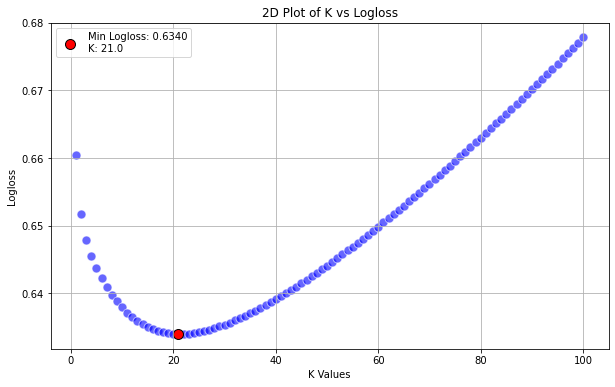

Minimum Logloss: 0.6340
Corresponding K: 21.0


In [7]:
# Extract values for plotting
K_values = results_df['K']
logloss = results_df['logloss']

# Create a 2D plot
plt.figure(figsize=(10, 6))
plt.scatter(K_values, logloss, c='blue', alpha=0.6, edgecolors='w', s=80)
plt.xlabel('K Values')
plt.ylabel('Logloss')
plt.title('2D Plot of K vs Logloss')

# Highlight the minimum logloss point
min_logloss_row = results_df.loc[results_df['logloss'].idxmin()]
min_K = min_logloss_row['K']
min_logloss = min_logloss_row['logloss']

plt.scatter(min_K, min_logloss, color='red', s=100, edgecolors='k', label=f'Min Logloss: {min_logloss:.4f}\nK: {min_K}')
plt.legend()

plt.grid(True)
plt.show()

# Print the corresponding K value
print(f'Minimum Logloss: {min_logloss:.4f}')
print(f'Corresponding K: {min_K}')

## Split Dataset:

In [8]:
all_matches_k['Date'] = pd.to_datetime(all_matches_k['Date'], format='%Y-%m-%d')
split_time = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
all_matches_k_train = all_matches_k[all_matches_k['Date'] < split_time]
all_matches_k_validation = all_matches_k[all_matches_k['Date'] >= split_time]


## Evaluate Model Performance


In [9]:
def calculate_metrics(data):
    # Calculate accuracy
    accuracy = np.mean(data.match_outcome == data.higher_rank_won)
    print(f'Accuracy: {accuracy}')

    # Calculate calibration
    calibration = np.sum(data.prob_high_ranked) / np.sum(data.higher_rank_won)
    print(f'Calibration: {calibration}')

    # Define log loss function
    def logloss(actual, predictions):
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        
        log_loss_value = -(1 / len(actual)) * np.sum(
            actual * np.log(predictions) + (1 - actual) * np.log(1 - predictions))
        return log_loss_value

    # Calculate log loss
    log_loss_value = logloss(data.higher_rank_won, data.prob_high_ranked)
    print(f'Log Loss: {log_loss_value}')

    return accuracy, calibration, log_loss_value

# Example usage with a dataset
accuracy_k, calibration_k, log_loss_k = calculate_metrics(all_matches_k_validation)


Accuracy: 0.6297724643270344
Calibration: 1.0281184988274965
Log Loss: 0.6339848683395303


In [11]:
# Create a DataFrame with the selected metrics
metric_comparison = pd.DataFrame({
    'model': ['K_Constant_25', 'K_Constant_Optimised'],
    'pred_acc': [results_df.iloc[24][2], accuracy_k],
    'log_loss': [results_df.iloc[24][1], log_loss_k],
    'calibration': [results_df.iloc[24][3], calibration_k]
})

# Print the DataFrame
print(metric_comparison)


                  model  pred_acc  log_loss  calibration
0         K_Constant_25  0.631315  0.634276     1.035876
1  K_Constant_Optimised  0.629772  0.633985     1.028118


## Extension 1:

In [12]:
# Load your dataset
df = all_matches_k_validation

# Define function to filter dataset for top N players
def filter_top_players(df, top_n):
    df_top = df[(df['WRank'] <= top_n) | (df['LRank'] <= top_n)]
    return df_top

# Filter the dataset for top 50 and top 100 players
df_top_50 = filter_top_players(df, 50)
df_top_100 = filter_top_players(df, 100)



In [13]:
accuracy_50, calibration_50, log_loss_50 = calculate_metrics(df_top_50)


Accuracy: 0.651175505740842
Calibration: 1.0540041270682576
Log Loss: 0.6157680743562562


In [14]:
accuracy_100, calibration_100, log_loss_100 = calculate_metrics(df_top_100)


Accuracy: 0.6327433628318584
Calibration: 1.0358075685232098
Log Loss: 0.6329405324694148


In [15]:
# Create a DataFrame to store the validation statistics
validation_stats = pd.DataFrame({
    'model': [
        'K_Constant_Optimised', 'K_Constant_Optimised Top 50', 'K_Constant_Optimised Top 100'
    ],
    'accuracy': [
        accuracy_k, accuracy_50, accuracy_100
    ],
    'log_loss': [
        log_loss_k, log_loss_50, log_loss_100
    ],
    'calibration': [
        calibration_k, calibration_50, calibration_100
    ]
})

# Print the validation statistics DataFrame
print(validation_stats)

                          model  accuracy  log_loss  calibration
0          K_Constant_Optimised  0.629772  0.633985     1.028118
1   K_Constant_Optimised Top 50  0.651176  0.615768     1.054004
2  K_Constant_Optimised Top 100  0.632743  0.632941     1.035808
